# Context Length Experiment

This notebook is to experiment how well ultra-long context LLMs can perform reasoning tasks over their context length. 

## Observation

Needle-in-a-haystack (NIH) tests test the ability of the LLM to find factoids that have been sprinkled randomly into the context. For example they might put things like "Pineapple is the best pizza topping" somewhere in all of the Paul Graham essays, then ask the LLM what is the best pizza topping. This is great for measuring how well the LLM can recall facts from its context but it doesnt measure how well the LLM can reason over 1M tokens of context.

This experiment will test that ability. We will fill the context window up gradually and measure how well the LLM can answer questions that require it to understand the entire context. 

## Hypothesis

My guess is that the agent will be able to perform these tasks with high accuracy in low context lengths, and the accuracy will drop off after a point. I also believe that the LLM will be close to accurate every time, but will not be 100% accurate after a certain threshold.


## Experiments

The way we will be able to evaluate the accuracy is by choosing tasks that we can validate programattically. So we cant just ask it for an analysis because we wont be able to descreetly validate the analysis results. We also want to avoid adding variables, so we won't want to include any tests that guage the ability of the LLM to count or function call for example. So in that case I thought of a few experiments:

1. Parse Titles - We ask the LLM to give us a list of all of the titles of all of the essays in order. We can write some regex scripts to parse that info ourselves and validate precision and recall and order correctness.
2. Parse Quotes - We ask the LLM to give us a list of all of the quotes that Paul Graham includes in his essays. We can then write regex to parse out everything wrapped in quotes (or `blockquotes`) and validate precision and recall
3. Ordered Instructions - We write a set of step by step instructions and break those steps up and sprinkle them randomly in the essays in order. We then ask the LLM to put those instructions together into the correct order and validate the accuracy.
4. Unordered Instructions - Same as the previous experiment but mix the order of the steps.
5. Parse Links - Parse out all of the href links from the essays and validate the accuracy of the LLM in parsing out the links.

### Utils

In [1]:
import re

def split_essays():
    """Split the Paul Graham essays"""
    with open("./paul_graham_essay.txt", "r") as file:
        essay_text = file.read()

    essays = []
    lines = []
    # Regex to match titles formatted as "Month Year"
    title_pattern = re.compile(r'^(January|February|March|April|May|June|July|August|September|October|November|December) \d{4}$')

    for line in essay_text.split('\n'):
        if title_pattern.match(line.strip()):
            # If we find a title and have collected lines for an essay, save the essay
            if lines:
                essays.append("\n".join(lines).strip())
                lines = []
        lines.append(line)

    # Add the last essay collected, if any
    if lines:
        essays.append("\n".join(lines).strip())

    # Randomize order
    return essays

essays = split_essays()

In [2]:
print(essays[-1])

April 2001

This essay developed out of conversations I've had with
several other programmers about why Java smelled suspicious.  It's not
a critique of Java!  It is a case study of hacker's radar.

Over time, hackers develop a nose for good (and bad) technology.
I thought it might be interesting to try and write down what
made Java seem suspect to me.

Some people who've read this think it's an interesting attempt to write about
something that hasn't been written about before.  Others say I
will get in trouble for appearing to be writing about
things I don't understand.  So, just in
case it does any good, let me clarify that I'm not writing here
about Java (which I have never used) but about hacker's radar
(which I have thought about a lot).

<hr>

The aphorism "you can't tell a book by its cover" originated in
the times when books were sold in plain cardboard covers, to be
bound by each purchaser according to his own taste.  In those days,
you couldn't tell a book by its cover.  But 

### Parse Titles Experiment

In [3]:
%pip install -qU langsmith langchain-openai python-dotenv pillow

Note: you may need to restart the kernel to use updated packages.


#### Dataset

We need to create a dataset that includes a list of indexes as the input and the expected titles in the output

In [4]:
def parse_titles(essays: list[str]):
    titles = []
    for essay in essays:
        title = essay.split("\n")[0]
        titles.append(title)
    return titles


def create_titles_dataset(essays=essays, chunks=8):
    examples = []
    for index in range(0, len(essays), chunks):
        # Current index and all indexes before it
        indexes = [i for i in range(index)]
        essays_to_parse = [essays[i] for i in indexes]

        if not indexes:
            continue

        examples.append({"inputs": {"indexes": indexes}, "outputs": {"titles": parse_titles(essays=essays_to_parse)}})

    return examples

In [5]:
examples = create_titles_dataset()
len(examples)


20

In [6]:
examples[0]

{'inputs': {'indexes': [0, 1, 2, 3, 4, 5, 6, 7]},
 'outputs': {'titles': ['September 2017',
   'January 2017',
   'January 2017',
   'November 2016',
   'April 2016',
   'January 2016',
   'January 2016',
   'January 2016']}}

Now lets upload them to a dataset in langsmith

In [7]:
from dotenv import load_dotenv
from langsmith import Client

load_dotenv()

client = Client()

def upload_title_dateset():
    dataset_name = "Context Experiment - Titles"

    # Storing inputs in a dataset lets us
    # run chains and LLMs over a shared set of examples.
    if client.has_dataset(dataset_name=dataset_name):
        dataset = client.read_dataset(dataset_name=dataset_name)
        return dataset
    else:
        dataset = client.create_dataset(
            dataset_name=dataset_name,
            description="Experiment to test the ability of the LLM to recall titles from essays.",
        )

    for i, example in enumerate(examples):
        client.create_example(
            inputs=example["inputs"],
            outputs=example["outputs"],
            dataset_name=dataset.name,
            metadata={"index": i}
        )

    return dataset


dataset = upload_title_dateset()
dataset

/Users/camronhaider/Documents/Dev/ContextLength-Experiment/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Dataset(name='Context Experiment - Titles', description='Experiment to test the ability of the LLM to recall titles from essays.', data_type=<DataType.kv: 'kv'>, id=UUID('a2d79adb-2bbd-4f01-bb11-a08716755d4b'), created_at=datetime.datetime(2024, 6, 16, 22, 33, 13, 417885, tzinfo=datetime.timezone.utc), modified_at=datetime.datetime(2024, 6, 16, 22, 33, 13, 417885, tzinfo=datetime.timezone.utc), example_count=20, session_count=3, last_session_start_time=datetime.datetime(2024, 6, 16, 22, 39, 52, 779145))

Okay now lets write the predict function

In [8]:
%pip install -qU langchain_core langchain-openai langchain-google-genai matplotlib

Note: you may need to restart the kernel to use updated packages.


In [9]:
from langchain_openai import ChatOpenAI
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.messages import SystemMessage, HumanMessage
from typing import List


class TitleSchema(BaseModel):
    """A list of ALL titles, including duplicates, in the order that they appear in the response."""

    titles: List[str] = Field(
        description="A list of ALL titles, including duplicates, in the order that they appear in the response."
    )


def llm_parse_titles(text: str, max_tokens=2000):
    """Use an LLM to parse the titles from the LLM output to an array"""
    llm = ChatOpenAI(model="gpt-4o", temperature=0.5,
                     max_tokens=max_tokens).with_structured_output(TitleSchema)
    system_prompt = """The user was tasked with analyzing and writing a list of titles that they found in some essays. \
Your job is to parse the user's response and return a list of titles that they mentioned. Be very exact! The integrity of your \
response is very important. If you are off by a single character or line item, you will be penalized!!"""
    response: TitleSchema = llm.invoke(
        [SystemMessage(content=system_prompt), HumanMessage(content=text)])
    return response

Now lets write the evaluations

In [10]:
from langsmith.schemas import Example, Run


def title_precision(root_run: Run, example: Example) -> dict:
    """The LLM's ability to only recall real titles from the expected list"""
    output_titles: list[str] = root_run.outputs.get("titles", [])
    expected_titles: list[str] = example.outputs["titles"]

    if not output_titles:
        return {"score": 0, "key": "precision", "comment": "No output titles provided"}

    score = 0

    expected_titles_copy = expected_titles.copy()

    false_positives = []
    for llm_title in output_titles:
        if llm_title in expected_titles_copy:
            score += 1
            expected_titles_copy.remove(llm_title)
        else:
            false_positives.append(llm_title)

    final_score = score / len(output_titles) if output_titles else 0.0
    comment = f"Titles not included in the example: {', '.join(false_positives)}"
    return {"score": final_score, "key": "precision", "comment": comment}


def title_recall(root_run: Run, example: Example) -> dict:
    """The LLM's ability to recall all real titles from the expected list"""
    output_titles: list[str] = root_run.outputs.get("titles", [])
    expected_titles: list[str] = example.outputs["titles"]

    total_expected_titles = len(expected_titles)
    output_titles_copy = output_titles.copy()
    score = 0
    missed_titles = []

    for expected_title in expected_titles:
        if expected_title in output_titles_copy:
            score += 1
            # Remove the title to account for duplicates
            output_titles_copy.remove(expected_title)
        else:
            missed_titles.append(expected_title)

    final_score = score / total_expected_titles if total_expected_titles else 0.0
    comment = f"Missed titles from the expected list: {', '.join(missed_titles)}"
    return {"score": final_score, "key": "recall", "comment": comment}


def title_order(root_run: Run, example: Example) -> dict:
    """The LLM's ability to order the titles correctly"""
    output_titles: list[str] = root_run.outputs.get("titles", [])
    expected_titles: list[str] = example.outputs["titles"]
    score = 0
    out_of_order_title = None

    for index, title in enumerate(expected_titles):
        try:
            if title.lower() == output_titles[index].lower():
                score += 1
            else:
                out_of_order_title = title
                break
        except:
            out_of_order_title = title
            break

    final_score = score / len(expected_titles) if expected_titles else 0.0
    comment = (
        f"First title out of order: {out_of_order_title}"
        if out_of_order_title
        else "All titles are in the correct order"
    )
    return {"score": final_score, "key": "order", "comment": comment}

Okay this seems good. Lets put it all together into an eval

/Users/camronhaider/Documents/Dev/ContextLength-Experiment/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


View the evaluation results for experiment: 'Flash-Large-6fd8d6a5' at:
https://smith.langchain.com/o/d967989d-4221-53db-b0a5-665b504acba2/datasets/a2d79adb-2bbd-4f01-bb11-a08716755d4b/compare?selectedSessions=365c88f0-b908-4407-879b-1cd0689b0494




0it [00:00, ?it/s]

Predicting...
AI selected 24/24 titles

Predicting...
AI selected 48/48 titles

Predicting...
AI selected 16/16 titles

Predicting...
AI selected 56/56 titles

Predicting...
AI selected 81/80 titles

Predicting...
AI selected 72/72 titles

Predicting...
AI selected 32/32 titles

Predicting...
AI selected 40/40 titles

Predicting...
AI selected 8/8 titles

Predicting...
AI selected 64/64 titles



10it [04:00, 24.04s/it]


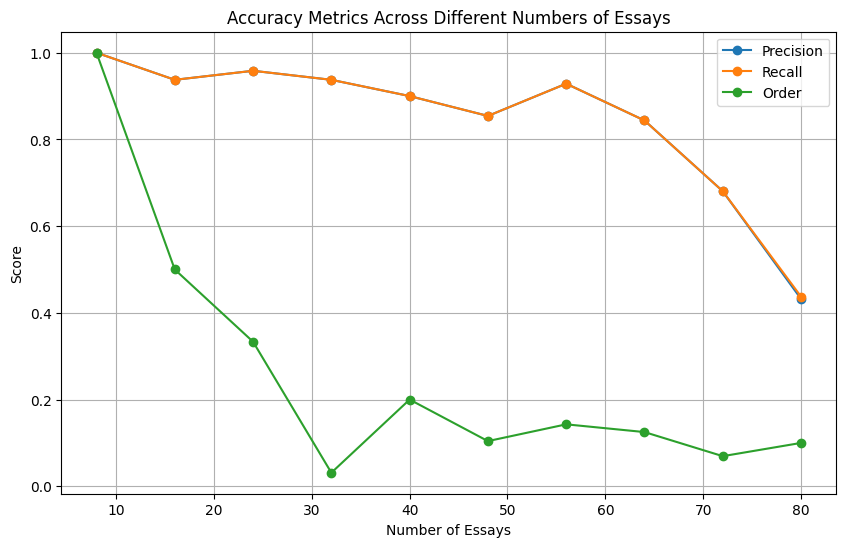

<ExperimentResults Flash-Large-6fd8d6a5>

In [11]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langsmith import evaluate
import time
import matplotlib.pyplot as plt


class TitlePredictor:
    def __init__(
        self,
        model="gemini-1.5-flash",
        prefix="Flash",
    ):
        self.model = model
        self.prefix = prefix
        self.results = None

    def predict_titles(self, inputs: dict):
        indexes: list[int] = inputs["indexes"]
        print(f"Trying with {len(indexes)} essays...")


        essays_for_context = [essays[i] for i in indexes]
        essay_str = "\n\n--------\n\n".join(essays_for_context)

        system_prompt = f"""You are a very thorough and detailed analyzer of Paul Graham essays. Your task it to analyze the \
provided essays and ONLY return a single list of titles in the order that they appear. You can tell which lines are titles because the \
contain ONLY a month and year followed by 2 new lines. For example: 'February 1993\n\n'. 

There are {len(indexes)} essays in <PAUL GRAHAM ESSAYS>. Return a numbered list of {len(indexes)} titles you have found. \
You will be graded on precision and recall so be sure to include ALL of the titles that actually appear in the essays and in the correct order. \
Some duplicates are expected, just be sure to be as accurate as possible!

Start your response with: 
'List of {len(indexes)} Titles:

1.'

<PAUL GRAHAM ESSAYS>
{essay_str}
</PAUL GRAHAM ESSAYS>"""

        # Max tokens is indexes * 10
        max_tokens = len(indexes) * 15

        retries = 3
        while retries > 0:

            try:
                llm = ChatGoogleGenerativeAI(
                    model=self.model, temperature=1, max_output_tokens=max_tokens + 50,
                )
                response = llm.invoke(system_prompt)
                if not response.content:
                    raise Exception("No content in response")

                titles = llm_parse_titles(response.content, max_tokens)

                if not titles.titles:
                    raise Exception("No titles in response")
                print(f"AI selected {len(titles.titles)}/{len(indexes)} titles\n")
                return {"response": response.content, "titles": titles.titles}
            except Exception as e:
                print(f"Error: {e}")
                retries -= 1
                # Wait 15 seconds
                time.sleep(60)
        return {"response": "", "titles": []}

    def evaluate(self, splits: list[str] = ["Tiny"], max_concurrency: int = 1, repetitions=1):
        self.results = evaluate(
            self.predict_titles,
            data=client.list_examples(dataset_id=dataset.id, splits=splits),
            evaluators=[title_precision, title_recall, title_order],
            experiment_prefix=f"{self.prefix}{f'-{splits[0]}' if splits else ''}",
            max_concurrency=max_concurrency,
            num_repetitions=repetitions,
        )
        self.visualize_title_results()
        return self.results

    def visualize_title_results(self):
        experiments = self.results._results
        results = []
        for experiment in experiments:
            essay_count = len(experiment['example'].inputs["indexes"])
            metrics = [{"key": metric.key, "score": metric.score}
                       for metric in experiment['evaluation_results']['results']]

            results.append({
                "essay_count": essay_count,
                "metrics": metrics
            })

        # Sort by essay_count
        results = sorted(results, key=lambda x: x['essay_count'])

        # Extract the data for plotting
        essay_counts = [result['essay_count'] for result in results]
        precision_scores = [next(metric['score'] for metric in result['metrics']
                                 if metric['key'] == 'precision') for result in results]
        recall_scores = [next(metric['score'] for metric in result['metrics']
                              if metric['key'] == 'recall') for result in results]
        order_scores = [next(metric['score'] for metric in result['metrics']
                             if metric['key'] == 'order') for result in results]

        # Plot the data
        plt.figure(figsize=(10, 6))

        plt.plot(essay_counts, precision_scores, marker='o', label='Precision')
        plt.plot(essay_counts, recall_scores, marker='o', label='Recall')
        plt.plot(essay_counts, order_scores, marker='o', label='Order')

        plt.xlabel('Number of Essays')
        plt.ylabel('Score')
        plt.title('Accuracy Metrics Across Different Numbers of Essays')
        plt.legend()

        plt.grid(True)
        plt.show()

        return results


response = TitlePredictor().evaluate(splits=["Large"])
response

In [12]:
response

<ExperimentResults Flash-Large-6fd8d6a5>